In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import kornia
import numpy as np
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import MIBIData
from modules import Denoiser
from criteria import DenoiserLoss
from modules import Estimator
from criteria import EstimatorLoss
import utils

In [2]:
main_dir = '/home/hazmat/GitHub/Denoiser/'
train_dir = main_dir + 'data/denoising_dataset/1024/'
modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'
# train_ds = MIBIData(folder=train_dir, crop=81, scale=1, stride=8)

In [4]:
denoiser_args = dict()
denoiser_args['dims'] =    [8, 16, 32, 8, 1]
denoiser_args['kernels'] = [3,  3,  3, 3, 3]

torch.cuda.empty_cache()
denoiser = Denoiser(**denoiser_args)
# denoiser = Denoiser.load_model(main_dir + 'denoiser/models/2020Mar09_14-55-38/', 'model_10')

denoiser.cuda()
denoiser_logger = Logger(['loss'])
denoiser_trainer = Trainer()

In [23]:
# Denoiser training parameters
denoiser_train_args = dict()
denoiser_train_args['lr'] = 0.0001
denoiser_train_args['batch_size'] = 100
denoiser_train_args['epochs'] = 10
denoiser_train_args['report'] = 5
denoiser_train_args['crop'] = 81
denoiser_train_args['clip'] = 1
denoiser_train_args['decay'] = 0
denoiser_train_args['restart'] = True
denoiser_train_args['epoch_frac'] = 0.1
# denoiser_train_args['decay'] = 1e-5

# Denoiser loss parameters
denoiser_criterion = DenoiserLoss()

In [24]:
denoiser.cuda()
denoiser_train_args['continue'] = True
# denoiser_trainer.train(denoiser, train_ds, denoiser_criterion, denoiser_logger, main_dir + 'denoiser/models/', **denoiser_train_args)

In [25]:
for i in range(10):
    train_ds = MIBIData(folder=train_dir, crop=81, scale=1, stride=8)
    denoiser_trainer.train(denoiser, train_ds, denoiser_criterion, denoiser_logger, main_dir + 'denoiser/models/', **denoiser_train_args)

Loading.......99.9%676
There are  2809000 samples
2809
Epoch:200 > < 0.10178729080962966                                                                                                               
Epoch:201 > < 0.10183316517846652                                                                                                               
Epoch:202 > < 0.10141357193266794                                                                                                               
Epoch:203 > < 0.10199697542657207                                                                                                               
Epoch:204 > < 0.1017793570323665                                                                                                                
Epoch:205 > < 0.10223495227241644                                                                                                               
Epoch:206 > < 0.10144681550191179                                          

Epoch:252 > < 0.10452010508533899                                                                                                               
Epoch:253 > < 0.1044329906432654                                                                                                                
Epoch:254 > < 0.10476012001231684                                                                                                               
Epoch:255 > < 0.10445064901510168                                                                                                               
Epoch:256 > < 0.10428379082197184                                                                                                               
Epoch:257 > < 0.10439562254131264                                                                                                               
Epoch:258 > < 0.10370704137266107                                                                                                 

In [26]:
# Load the data
leeat_ds = MIBIData(folder='/home/hazmat/GitHub/Denoiser/data/Point15/TIFs/', crop=81, scale=1, stride=8)

Loading.......98.24561403508773%%3364
There are  780273 samples


<IPython.core.display.Javascript object>


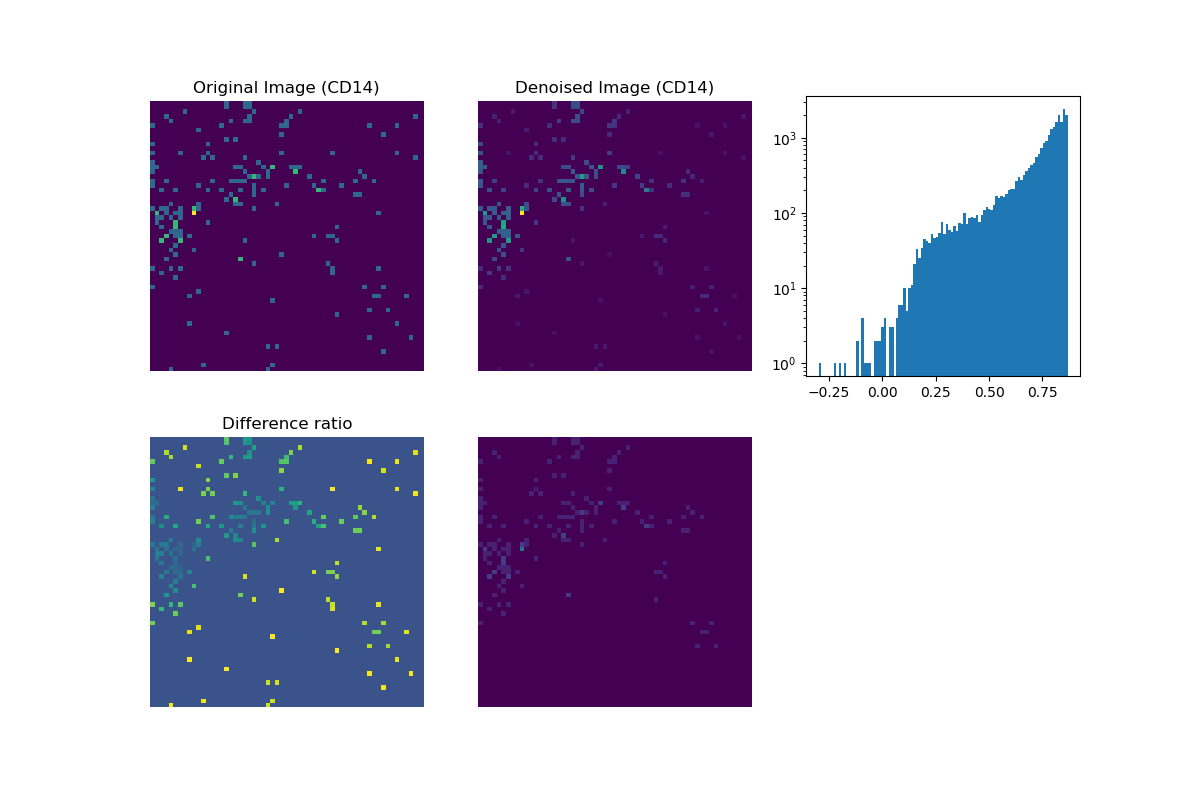

A Jupyter Widget

In [29]:
from ipywidgets import *
from scipy.ndimage import gaussian_filter
from time import gmtime, strftime
import skimage

img = leeat_ds.images[0]
img = img.unsqueeze(0)

sz = 8
fig1 = plt.figure(figsize=(sz/2*3,sz))
global img

def update(lam=0, cmax=1, threshold=0.5):
    global img
    x_lam = torch.zeros(img.shape)+lam
    print(x_lam.shape)
    dimg = denoiser.denoise(img.cuda(), x_lam)
    
    diff = -(dimg.cpu()-img)/img;
    diff[torch.isinf(diff)]=0
    diff = diff[0,0,:,:]
    diff = diff[10:-10:1, 10:-10:1]
    diff = diff.cpu().detach()
    data = diff[diff!=0]
    
    kimg = img[0,0,:,:].cpu().detach()
    kimg = kimg[10:-10:1, 10:-10:1]
    nimg = torch.zeros(kimg.shape)
    nimg[diff<threshold] = kimg[diff<threshold]
    # blur=1
    # nimg = torch.tensor(skimage.filters.gaussian(nimg.numpy(), blur))
    
    dimg = dimg[0,0,:,:].cpu().detach()
    dimg = dimg[10:-10:1, 10:-10:1]
    
    if True:
        ax1 = plt.subplot(2,3,1)
        plt.imshow(kimg, vmax=cmax)
        plt.axis('off')
        plt.title('Original Image (CD14)')

        plt.subplot(2,3,2, sharex=ax1, sharey=ax1)
        # plt.imshow(dimg-kimg, vmax=cmax)
        plt.imshow(dimg, vmax=cmax)
        plt.axis('off')
        plt.title('Denoised Image (CD14)')

        try:
            plt.subplot(2,3,3)
            plt.cla()
            plt.hist(data,100, log=True)
        except:
            pass
            
        plt.subplot(2,3,4, sharex=ax1, sharey=ax1)
        plt.imshow(diff)
        plt.axis('off')
        plt.title('Difference ratio')

        plt.subplot(2,3,5, sharex=ax1, sharey=ax1)
        plt.imshow(nimg)
        plt.axis('off')
    else:
        blur=1
        nimg = torch.tensor(skimage.filters.gaussian(dimg.numpy(), blur))
        plt.imshow(nimg)
    
#     plt.subplot(1,3,3)
#     plt.imshow(kimg-dimg)
#     plt.axis('off')
#     plt.title('Difference')
    
    print(strftime('%H:%M:%S', gmtime()))
    print(torch.mean(kimg-dimg))
    
interact(update, lam=widgets.FloatSlider(value=0.14, min=-0.1, max=1, step=0.01), cmax=widgets.IntSlider(value=3, min=0, max=20, step=1), threshold=widgets.FloatSlider(values=1, min=0, max=1, step=0.01));